# Faraji Case Study

## Markov Chain Monte Chain (MCMC) 
Markov Chain Monte Carlo 
The model approach here is in two parts - one part for the U-Th ages and unique estimates of 230Th0 and the other part for the age-depth model. In the following section we will describe in detail the various moves taken in each part of the modeling method. 
U-Th ages and unique 230Th0
The first part of the model is focussed on making estimates of the U-Th ages. These ages are constructed using the measured activity ratios and estimates of initial 230Th0 for each sample in a given speleothem. There are two moves in this MCMC; (1) Move the measured ratios and; (2) Move the initial thorium. In the measured ratio move, we perform a joint Metropolis-Hastings update of the three activity ratios (230Th/238U, 232Th/238U, and234U/238U) at a single sample index. First, we extract the current 3-vector of ratios at that index and fetch its estimated covariance matrix from the in-built function in the model. We then draw a zero-mean multivariate Gaussian step using that covariance, scaled by the tuning-factor and add it to the current ratio to generate a 3-vector proposal of ratios. If any of the proposal ratios are negative - violating physical bounds- we immediately reject. Otherwise we splice these new values into copies of the full ratio arrays to form a complete proposal parameter set, we term $\theta$’. We compute the log-likelihood (LL) and log-prior (Lp) at both the current state - termed $\theta$ - and the proposed state $\theta$’. If either evaluation returns - (an impossible or “zero-probability” state), we reject. Otherwise, we calculate the usual Metropolis acceptance log-ratio, 

<br>

log($\alpha$) = (Lp($\theta$') + LL(y|$\theta$')) -  ((Lp($\theta$) + LL(y|$\theta$)))

<br>
And accept the move with probability min(1, $\alpha$). A uniform random (u) draw decides acceptance: if log(u) < log($\alpha$), we accept and return the proposed values. Otherwise we reject and retain the current ratios. 
	The second form of these moves is to update 230Th0. This move is identical to the previous except for the proposal mechanism. Unlike the previous move, we use a zero mean gaussian centered on zero with a scale determined by the adaptive tuning factors. After making a proposal for a chosen index we perform an identical operation as described above. 



# The Likelihood Function
--------------------------
The most important part of this MCMC is the likelihood function. 
We requrie a unique likelihood function that maximies the stratigraphic information and accounts for the measurement uncertainty for each sample.

The likelihood is described as: 

$
\mathcal{LL_{strat}}
= \sum_{i=1}^{n-1}
  \sum_{j=i+1}^{n}
  \ell_{ij},
$
where
$
\ell_{ij} =
\begin{cases}
0,
& a_j - a_i > 0, \\[6pt]
\log \Phi\!\bigl(\tfrac{a_j - a_i}{\sigma_{ij}}\bigr),
& a_j - a_i \le 0
  \quad\text{and}\quad
  |a_j - a_i| > \sigma_{ij}, \\[6pt]
\log \Phi\!\bigl(\tfrac{a_j - a_i}{\zeta\,\sigma_{ij}}\bigr),
& \text{otherwise},
\end{cases}
$
with
$
\Delta_{ij} \equiv a_j - a_i,\quad
\sigma_{ij} \equiv \sqrt{\sigma_i^2 + \sigma_j^2},\quad
\zeta = 3,
$
and ($\Phi$) the standard normal cumulative distribution function.


### What its doing
-------------------
Penalizing age inversions with respect to the observed uncertainty and does this across all samples. We define the stratigraphic log-likelihood, LLstrat, by summing contributions over every pair of samples (i,j) with i < j. For each pair, if the sample at a lower depth, j, is older than the shallower, i, the penalty is 0. If the deeper age is younger by more than the combined uncertainty we assign a strong penalty. And if this reversal, deeper age is younger but within combined uncertainty we apply a softer penalty. By accumulating these pairwise terms, LL$_{strat}$ rewards stratigraphically consistent age sequences while penalizing inversions proportional to their magnitude relative to the observed uncertainty. 


## Faraji Example
-----------------
In this jupyer notebook we show an example of a young <400 year old speleothem from tropical pacific documented by Faraji et al. (2021). This dataset provides a unique opportunity for validation as there is an accompanying laminae counting age model. Faraji et al. (2021) assume the accuracy of the age model and back-calculate the ($^{230}$Th/$^{232}$Th)$_{A0}$ required to align both the U-Th ages and lamina counting chronology. The authors report a set of unique sample specific ($^{230}$Th/$^{232}$Th)$_{A0}$ for each of the 10 measured U-Th samples from the Speleothem. Here we use ThoTh to examine if we can reutrn a prior that captures the variable and also most likely values. This is shown below. 

In [42]:
import sys 

sys.path.append(f'{filepath}Initial_Thorium')

In [43]:
from ibis_codes_KDE import IBIS_2
from ibis_codes_KDE import IBIS_MCMC_Initial_Th


In [3]:
faraji = IBIS_2.IBIS('Faraji_2021_data.xlsx', 
                     sample_name = 'Faraji_Case_Study', 
                     MCMC_samples = 100000, 
                     MCMC_burn_in = 20000,
                     n_chains = 3, 
                     Start_from_pickles=True,
                     show_bird= False, 
                     MCMC_Strat_samples= 250000)


Data loaded successfully from /Users/jackcarter/Desktop/Useries_InT_paper/Faraji_2021_data.xlsx


In [44]:
faraji.Get_IBIS_Bounds(); 

Thorium Prior Loaded
12.908419256217535


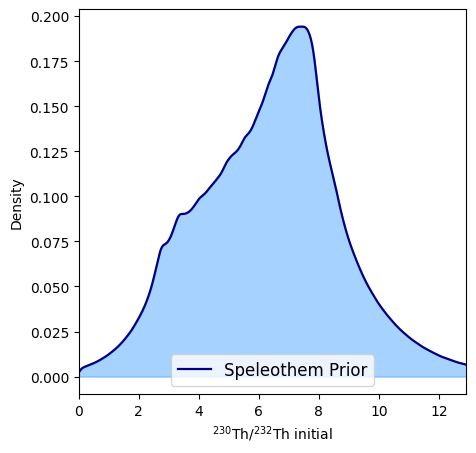

In [59]:
faraji.Plot_Priors()

In [25]:
mcmc_InT = IBIS_MCMC_Initial_Th.IBIS_MCMC(faraji.Thor_prior, faraji.age_max, 
                                          faraji.age_uncertainties, faraji.df_reduced, 
                                        iterations=100000, burn_in=50000)

In [26]:
mcmc_InT.Run_MCMC(); 

Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True


# Posterior Traceplot

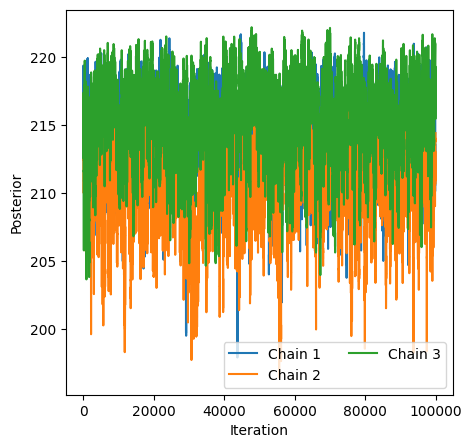

In [31]:
mcmc_InT.Get_Posterior_plot()

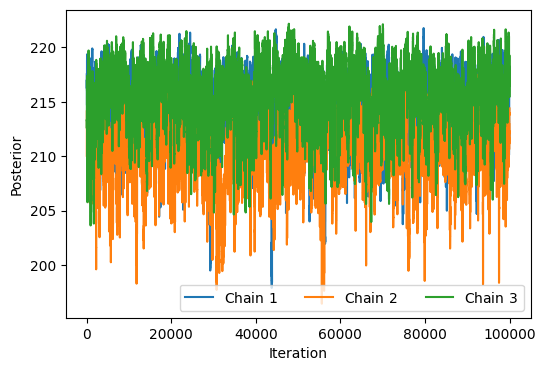

In [60]:
# Grab Chain results and plot posterior directly for paper supplement

 
results_dict = mcmc_InT.Get_Results_Dictionary()

log_p = []
for i in range(1, mcmc_InT.n_chains + 1): 
    chain_dict = results_dict[i-1]  # get the dictionary for chain i
    log_p.append(chain_dict[f"z6_{i}"])

fig, ax = plt.subplots(1, 1, figsize  = (6, 4))
for i in range(mcmc_InT.n_chains): 
    ax.plot(log_p[i], 
           label = f'Chain ${i+1}$')
ax.set_xlabel('Iteration')
ax.set_ylabel('Posterior')
ax.legend(frameon = True, loc = 4, fontsize = 10, ncol = mcmc_InT.n_chains)


# Gelman-Rubin statistic
- The Gelman-rubin statistic accounts for both between-chain and within-chain variability. A value close to unity is indicative of good chain mixing and convergence. 

In [32]:
# Initial thorium values
mcmc_InT.In_Thor_Chain_Stats()

array([1.10713128, 1.00637358, 1.03727114, 1.05099176, 1.07912876,
       1.00362644, 1.0001046 , 1.03827168, 1.0669574 , 1.00933859])

In [33]:
# U-Th ages
mcmc_InT.Useries_Age_Chain_Stats()

array([1.00097289, 1.0033766 , 1.00429959, 1.01233519, 1.00817868,
       1.01566748, 1.01672945, 1.01301658, 1.02107704, 1.04075328])

In [34]:
age, age_err = mcmc_InT.Get_Useries_Ages()
df_reduced = mcmc_InT.data
depths = df_reduced['Depths'].values

Text(0.5, 0, 'Age (a)')

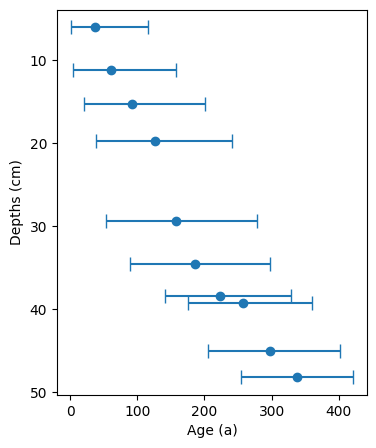

In [35]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1, figsize = (4, 5))

ax.errorbar(x = age, 
            xerr = np.array([age_err[0], 
                             age_err[1]]), 
            y = depths, 
            fmt = 'o', 
           capsize = 5)
ax.invert_yaxis()
ax.set_ylabel('Depths (cm)')
ax.set_xlabel('Age (a)')

In [36]:
mcmc_InT.Get_Initial_Thoriums()

(array([8.06366511, 6.13470547, 6.03826401, 6.76685534, 7.76515493,
        6.86017785, 6.76151199, 6.43531584, 6.86390932, 4.60197181]),
 [array([0.38077428, 1.00876105, 1.25357343, 1.15837513, 0.188909  ,
         0.62437444, 2.49131853, 2.24626387, 1.24105627, 3.71235442]),
  array([0.28003177, 0.61748075, 0.81824981, 0.89647363, 0.17990957,
         0.55977105, 1.97238442, 1.77541095, 1.07520134, 3.73286914])])

In [37]:
thor_model, thor_model_err = mcmc_InT.Get_Initial_Thoriums()

In [38]:
Faraji_Th = np.array([8.05, 6.00, 5.98, 6.63, 7.74, 6.55, 6.01, 6.21, 6.87, 4.88])
Faraji_Th_err = np.array([0.24, 0.25, 0.27, 0.25, 0.18, 0.21, 0.50, 0.46, 0.27, 0.97])

In [39]:
depths = faraji.df_reduced['Depths'].values

# Model Validation

Faraji et al. (2021) back-calculate the ($^{230}$Th/$^{232}$Th)$_{A0}$ required to align both the U-Th ages and lamina counting chronology. We compare these to the IBIS-derived estimates as a test of model validation. We show this in the plot below. 

## Results
----------
All IBIS-derived results are statistically indistinguishable from the back-calcualted values reported by Faraji et al. (2021). In the majority of cases the IBIS-derived uncertainty is greater than the back-calculated value. However, the is a remarkable increase in accuracy of the U-Th ages using IBIS. We conclude that sacrificing precision for accuracy is the "best" way to analyse complex data of this type. 

Text(0.5, 0, '$^{230}$Th$^{232}$Th$_{A0}$ (units)')

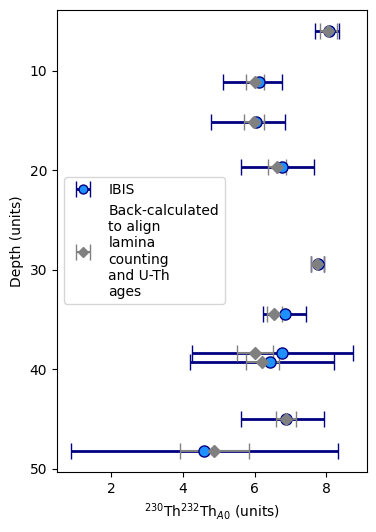

In [40]:
fig, ax = plt.subplots(1, 1, figsize = (4, 6))
ax.errorbar(y = depths, x = thor_model, xerr = thor_model_err, 
            
            fmt = 'o', capsize = 6, 
           label = 'IBIS', markerfacecolor = 'dodgerblue', 
           markeredgecolor = 'navy', ecolor = 'navy', 
           markersize = 8, lw = 2)

ax.errorbar(y = depths, x = Faraji_Th, xerr = Faraji_Th_err, 
            fmt = 'D', capsize = 6, 
           label = 'Back-calculated\nto align\nlamina\ncounting\nand U-Th\nages', 
           color = 'grey')

ax.invert_yaxis()
ax.legend(markerscale = 0.8)
ax.set_ylabel('Depth (units)')
ax.set_xlabel('$^{230}$Th$^{232}$Th$_{A0}$ (units)')